# Practical Lab 1 — Regression-Based Predictive Maintenance Alerts (Threshold Discovery Notebook)

**Goal:** Train univariate linear regression models (**Time → Axes #1–#8**), analyze residuals (**Observed − Predicted**), and **discover data-driven thresholds** (**MinC**, **MaxC**, **T**) for Alert/Error events.  
This notebook also generates evidence (tables + plots) to justify the chosen thresholds for the rubric.


In [2]:
# --- Path + imports (run this FIRST) ---
import os, sys
from pathlib import Path

# Find project root (folder containing "src")
p = Path.cwd().resolve()
while not (p / "src").exists() and p != p.parent:
    p = p.parent
PROJECT_ROOT = p

# Add project root to sys.path so "import src" works
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)
print("src exists:", (PROJECT_ROOT / "src").exists())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Project imports
from src.config import TIME_COL, AXIS_COLS, THRESHOLDS_PATH, DB_HOST, DB_NAME
from src.db import read_training_data


Project root: C:\Users\kevin\Downloads\PredictiveMaintenance_Streaming_Lab1_UPDATED\PredictiveMaintenance_Streaming_Lab1_UPDATED
src exists: True


## Why regression + residuals?

A regression line estimates the **expected** current over time.  
The **residual** is:

**Residual = Observed − Predicted**

In predictive maintenance, **sustained positive residuals** (current consistently above expected) can indicate abnormal load, friction, wear, or early mechanical issues.  
So residuals are a practical, evidence-based signal for Alert/Error thresholds.


In [3]:
# --- Load training data (DB first, then CSV fallback) ---
use_db = bool(DB_HOST and DB_NAME)

train = pd.DataFrame()
if use_db:
    try:
        train = read_training_data()
        print("Loaded training data from DB:", train.shape)
    except Exception as e:
        print("DB not available; falling back to CSV. Error:", e)

if train.empty:
    csv_path = PROJECT_ROOT / "data" / "training" / "RMBR4-2_export_test.csv"
    print("Loading training CSV from:", csv_path)
    if not csv_path.exists():
        raise FileNotFoundError(f"Training CSV not found at: {csv_path}")
    train = pd.read_csv(csv_path)
    print("Loaded training data from CSV:", train.shape)

train.head()


C:\Users\kevin\Downloads\PredictiveMaintenance_Streaming_Lab1_UPDATED\PredictiveMaintenance_Streaming_Lab1_UPDATED\src\db.py:117: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(q, conn)


Loaded training data from DB: (2000, 11)


,id,time_s,axis_1,axis_2,axis_3,axis_4,axis_5,axis_6,axis_7,axis_8,created_at
0,1,0.0,11.121887,11.819220,13.101282,14.090047,15.133441,16.070511,16.876085,17.927340,2026-02-07 04:18:06.287286+00:00
1,2,1.0,10.585506,11.736649,13.362587,13.984663,15.502037,16.368648,17.034593,18.440095,2026-02-07 04:18:06.287286+00:00
2,3,2.0,11.303180,12.179604,13.118328,14.357615,15.501328,15.429085,16.524686,18.915367,2026-02-07 04:18:06.287286+00:00
3,4,3.0,11.380726,12.109741,13.909030,14.260686,14.842103,15.912856,16.476360,18.107804,2026-02-07 04:18:06.287286+00:00
4,5,4.0,10.225586,11.450081,13.589908,12.829654,15.107574,16.367604,17.114828,18.045235,2026-02-07 04:18:06.287286+00:00


## Modeling approach

For each axis (1–8):

1. Fit a **univariate linear regression** model: **Time → Axis**
2. Predict expected current for each timestamp
3. Compute residuals: **Observed − Predicted**
4. Analyze residual distributions and percentiles to choose **MinC** and **MaxC**
5. Choose a sustained duration **T** (seconds) to reduce false positives from noise


In [4]:
# --- Fit regressions + compute residuals (CORRECT for your src/regression.py) ---
from src.regression import fit_models, residuals

# Train models for all axes
models = fit_models(train, TIME_COL, AXIS_COLS)

# Compute residuals for each axis
residuals_map = {}
yhat_map = {}

for ax in AXIS_COLS:
    r, yhat = residuals(train, TIME_COL, ax, models[ax])
    residuals_map[ax] = r
    yhat_map[ax] = yhat

print("Trained models:", len(models))
print("Axes:", AXIS_COLS)
print("Example model:", AXIS_COLS[0], models[AXIS_COLS[0]])


Trained models: 8
Axes: ['axis_1', 'axis_2', 'axis_3', 'axis_4', 'axis_5', 'axis_6', 'axis_7', 'axis_8']
Example model: axis_1 {'intercept': 11.058566507305173, 'slope': 0.00045616614962963495}


## Visual evidence: regression plots (training)

These plots show the baseline trend (regression line) for each axis.


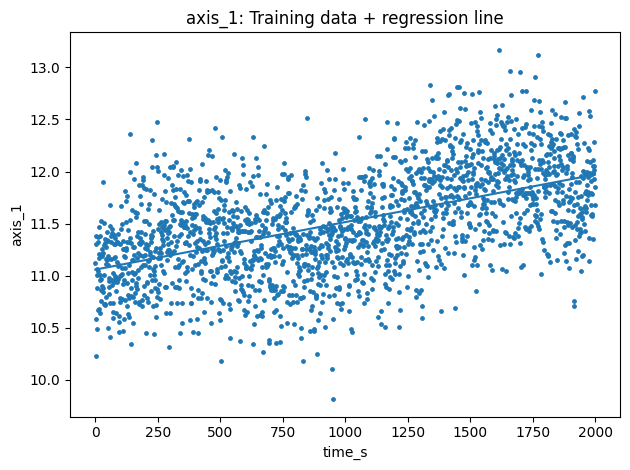

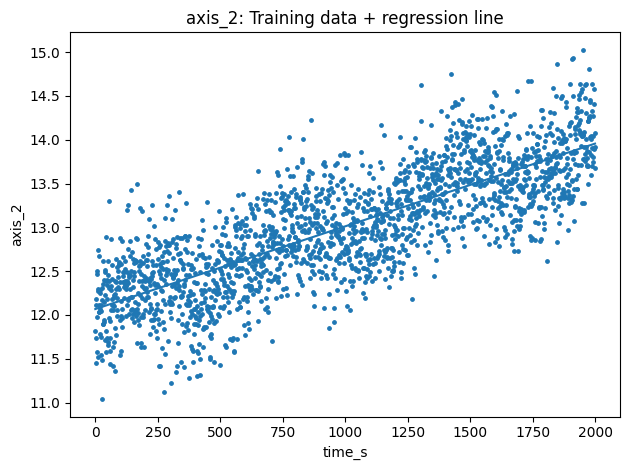

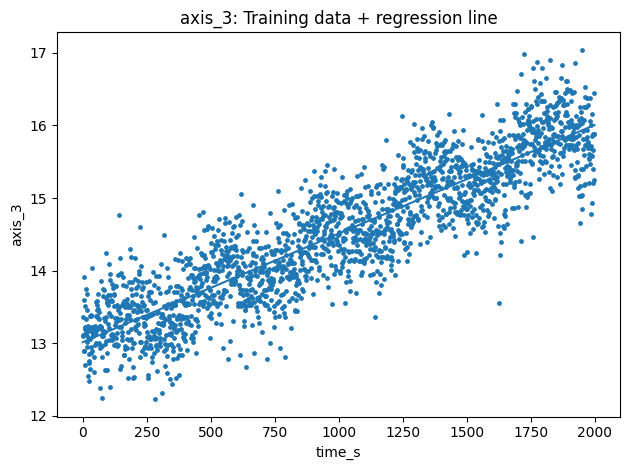

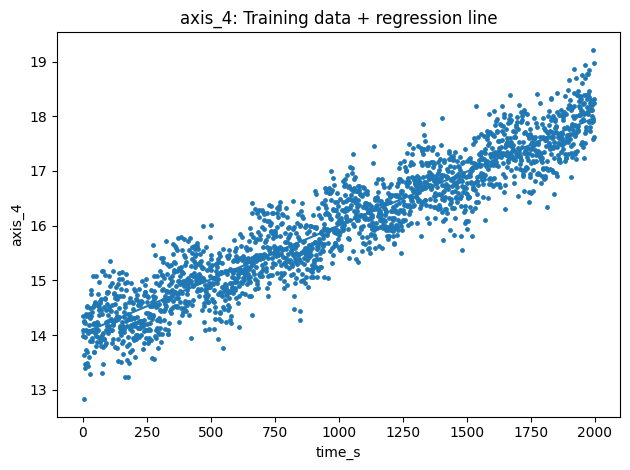

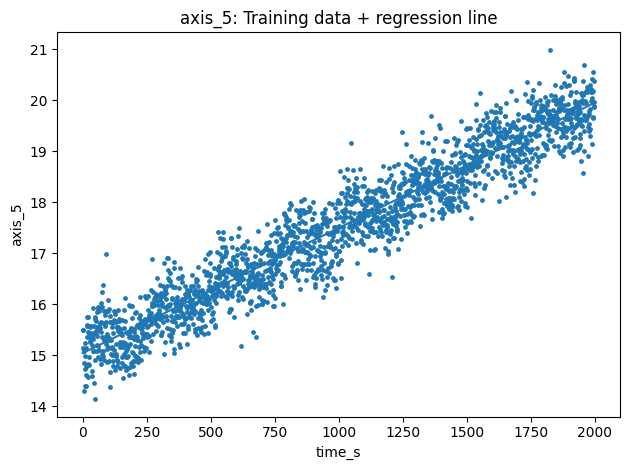

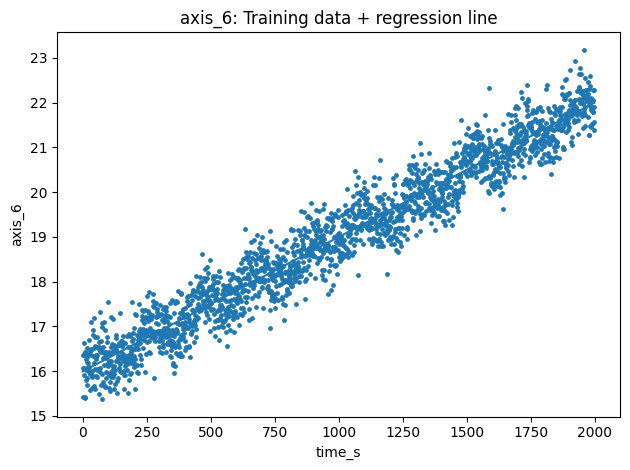

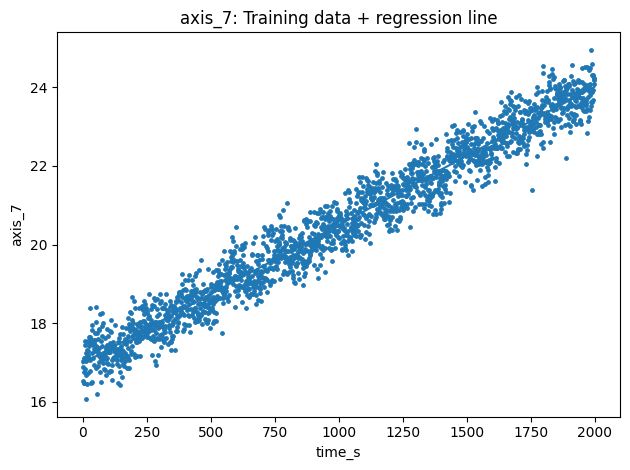

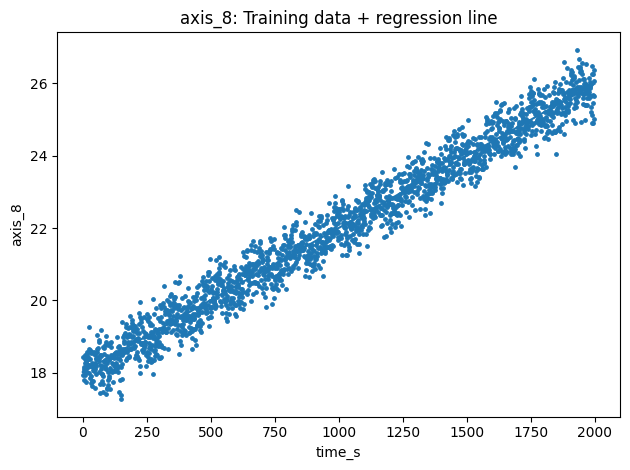

Saved figures to: C:\Users\kevin\Downloads\PredictiveMaintenance_Streaming_Lab1_UPDATED\PredictiveMaintenance_Streaming_Lab1_UPDATED\outputs\figures
Example model object: axis_1 {'intercept': 11.058566507305173, 'slope': 0.00045616614962963495}


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def get_b0_b1(model):
    """Return intercept (b0) and slope (b1) from different model formats."""
    # dict formats
    if isinstance(model, dict):
        if "b0" in model and "b1" in model:
            return float(model["b0"]), float(model["b1"])
        if "intercept" in model and "slope" in model:
            return float(model["intercept"]), float(model["slope"])
        if "a" in model and "b" in model:
            return float(model["a"]), float(model["b"])
        # sometimes keys are uppercase
        if "B0" in model and "B1" in model:
            return float(model["B0"]), float(model["B1"])
        raise KeyError(f"Unknown model dict keys: {list(model.keys())}")

    # tuple/list formats
    if isinstance(model, (tuple, list)) and len(model) >= 2:
        return float(model[0]), float(model[1])

    raise TypeError(f"Unsupported model type: {type(model)}")

fig_dir = PROJECT_ROOT / "outputs" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

for ax in AXIS_COLS:
    b0, b1 = get_b0_b1(models[ax])

    x = train[TIME_COL].values
    y = train[ax].values
    yhat = b0 + b1 * x

    plt.figure()
    plt.scatter(x, y, s=6)
    order = np.argsort(x)
    plt.plot(x[order], yhat[order])
    plt.title(f"{ax}: Training data + regression line")
    plt.xlabel(TIME_COL)
    plt.ylabel(ax)
    plt.tight_layout()

    out = fig_dir / f"regression_{ax}.png"
    plt.savefig(out, dpi=200)
    plt.show()

print("Saved figures to:", fig_dir)
print("Example model object:", AXIS_COLS[0], models[AXIS_COLS[0]])


## Residual analysis (evidence)

To discover thresholds, I inspect residual distributions and compute percentiles:

- **MinC (Alert):** high-but-not-extreme deviation (often ~95th–97.5th percentile)
- **MaxC (Error):** extreme deviation (often ~99th percentile)

Using percentiles is defensible because it ties thresholds directly to empirical training behavior.


In [6]:
import numpy as np
import pandas as pd

# --- Residual percentile table (evidence) ---
rows = []
for ax in AXIS_COLS:
    r = np.asarray(residuals_map[ax])  # ✅ use residuals_map, not residuals()
    rows.append({
        "axis": ax,
        "p90": float(np.percentile(r, 90)),
        "p95": float(np.percentile(r, 95)),
        "p97_5": float(np.percentile(r, 97.5)),
        "p99": float(np.percentile(r, 99)),
        "max": float(np.max(r)),
        "mean": float(np.mean(r)),
        "std": float(np.std(r))
    })

thr_table = pd.DataFrame(rows).sort_values("axis").reset_index(drop=True)
thr_table


,axis,p90,p95,p97_5,p99,max,mean,std
0,axis_1,0.540978,0.686382,0.830626,0.996883,1.372880,6.927792e-17,0.420349
1,axis_2,0.523694,0.678088,0.821338,0.985767,1.346693,4.094503e-16,0.418182
2,axis_3,0.546052,0.684608,0.846677,0.998551,1.538153,4.956036e-16,0.431892
3,axis_4,0.557303,0.736369,0.874421,0.989866,1.258868,-1.447731e-15,0.425744
4,axis_5,0.547164,0.697514,0.816723,0.994498,1.725349,2.015277e-15,0.429852
5,axis_6,0.544345,0.713860,0.859371,1.000397,1.556228,-8.384404e-16,0.428582
6,axis_7,0.555209,0.709189,0.832749,0.994532,1.378125,4.110490e-15,0.420861
7,axis_8,0.557635,0.700050,0.805988,0.939019,1.218142,-2.637890e-15,0.420731


### Residual distribution plots

Histograms help show typical spread and outliers.  
Boxplots are useful for comparing axes.


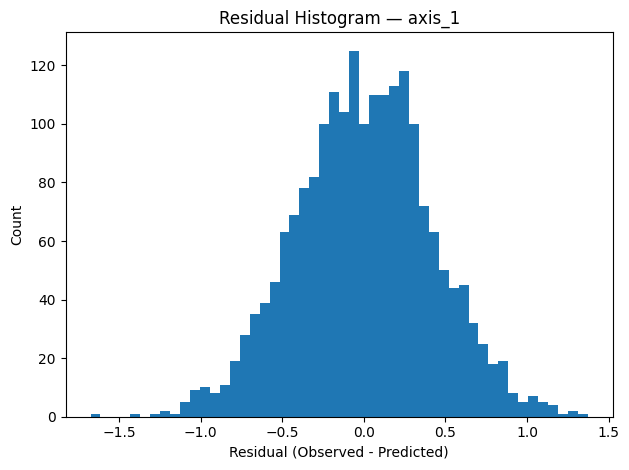

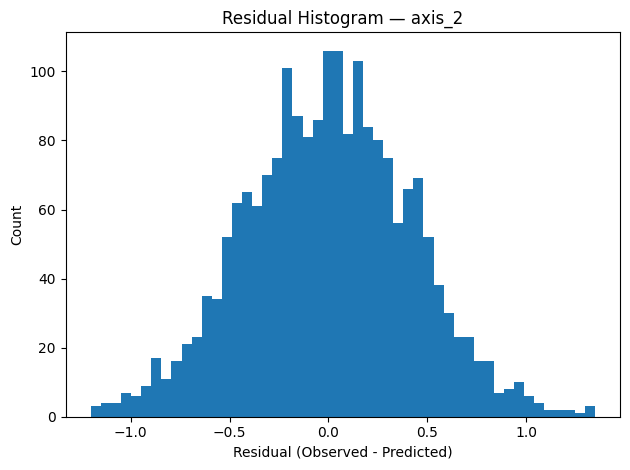

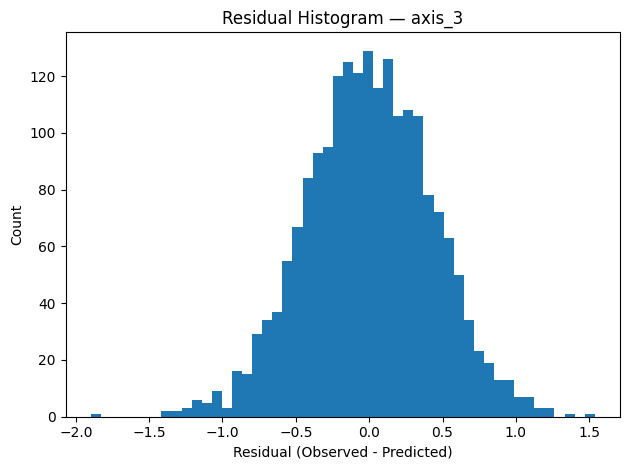

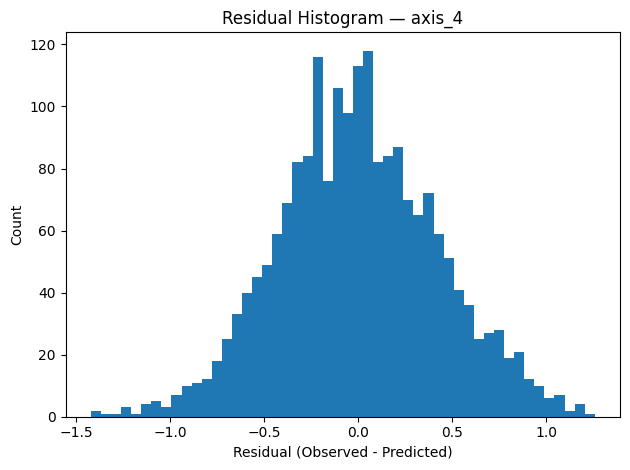

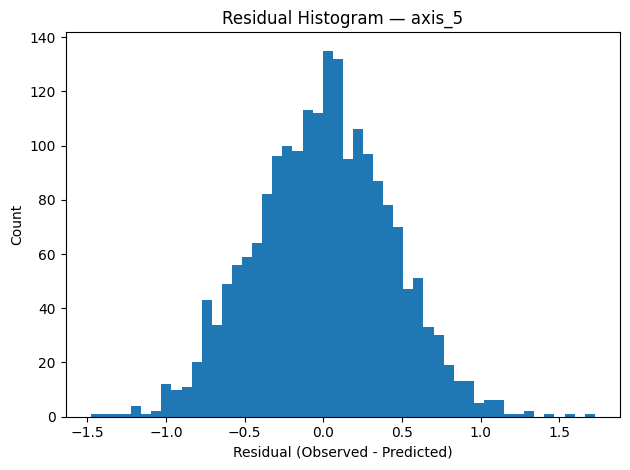

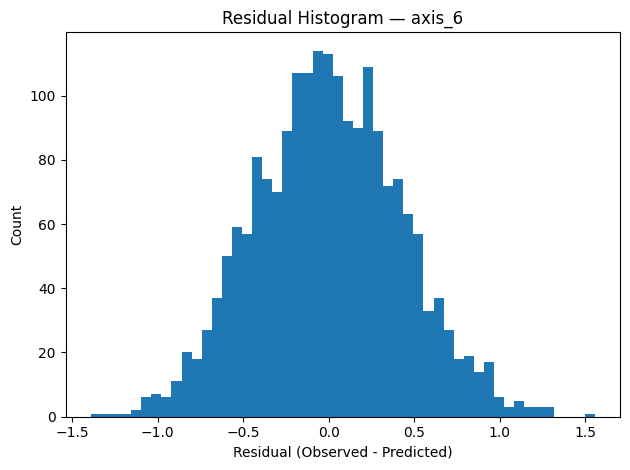

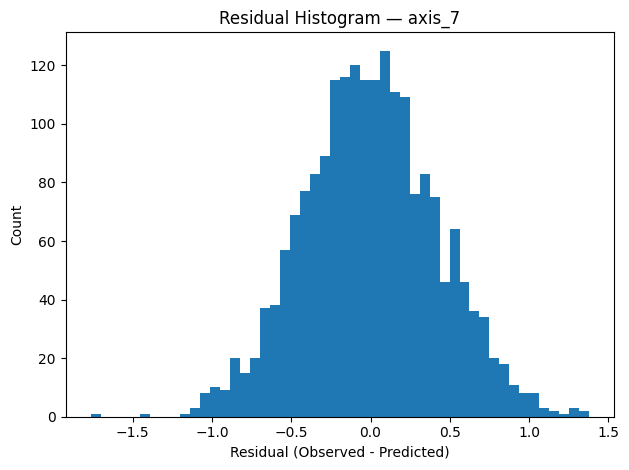

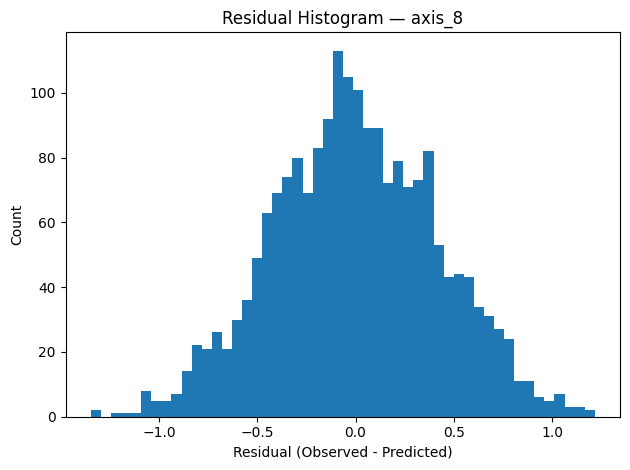

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --- Residual histograms (one per axis) ---
for ax in AXIS_COLS:
    r = np.asarray(residuals_map[ax])

    plt.figure()
    plt.hist(r, bins=50)
    plt.title(f"Residual Histogram — {ax}")
    plt.xlabel("Residual (Observed - Predicted)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


C:\Users\kevin\AppData\Local\Temp\ipykernel_24540\3212840401.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=AXIS_COLS, showfliers=True)


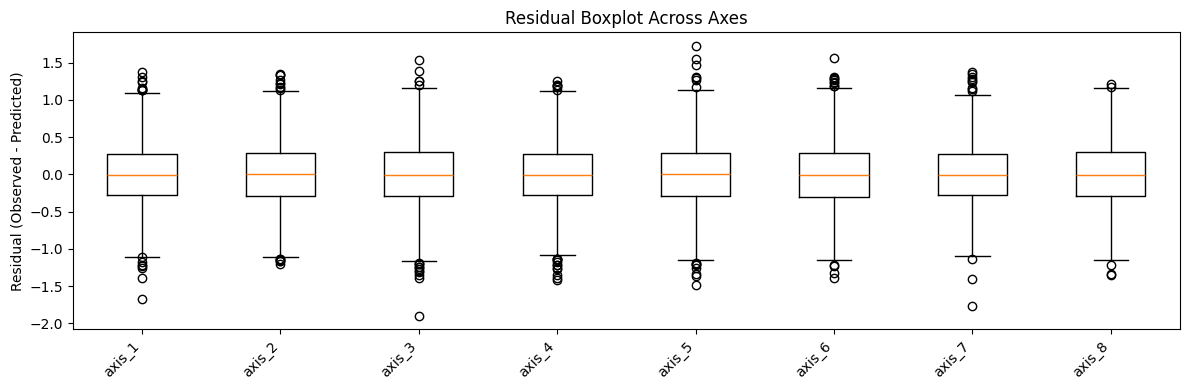

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# --- Residual boxplot across axes ---
plt.figure(figsize=(12, 4))

data = [np.asarray(residuals_map[ax]) for ax in AXIS_COLS]

plt.boxplot(data, labels=AXIS_COLS, showfliers=True)
plt.title("Residual Boxplot Across Axes")
plt.ylabel("Residual (Observed - Predicted)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Choose MinC and MaxC (global thresholds)

To keep the rules simple for the streaming pipeline, I choose **global thresholds** across axes using residual percentiles.

A practical choice:
- **MinC** = average of **p97.5** across axes
- **MaxC** = average of **p99** across axes

This yields consistent detection logic while still being data-driven.


In [9]:
# --- Compute global thresholds from training residual percentiles ---
MinC = float(thr_table["p97_5"].mean())
MaxC = float(thr_table["p99"].mean())

MinC, MaxC


(0.8359866425373002, 0.9874391762248544)

## Choose T (sustained duration)

Single-point spikes can be noise. I require residuals to stay above thresholds **continuously** for at least **T** seconds.

I test multiple candidates and choose the smallest T that reduces noise-triggered alerts while still detecting sustained abnormal segments.


In [10]:
# --- Choose T candidates (edit if needed) ---
T_candidates = [5.0, 10.0, 15.0, 20.0]
T_candidates


[5.0, 10.0, 15.0, 20.0]

In [11]:
# --- Quick validation using synthetic test data (counts by T) ---
import numpy as np
import pandas as pd

from src.synthetic_generator import generate_synthetic, inject_anomalies
from src.preprocessing import fit_train_scalers, transform_zscore
from src.regression import fit_models, residuals
from src.detector import RuleConfig, detect_events_for_axis

# ---- 1) Fit scalers on training ----
scalers = fit_train_scalers(train, AXIS_COLS)

# ---- 2) Standardize training (Z-score) and fit models ----
train_z = transform_zscore(train, AXIS_COLS, scalers)
models_z = fit_models(train_z, TIME_COL, AXIS_COLS)

# ---- 3) Generate synthetic test data (based on training stats) ----
# n_rows=300 at 1 Hz ~= 300 seconds
test = generate_synthetic(train, TIME_COL, AXIS_COLS, n_rows=300, seed=42)

# OPTIONAL: inject one sustained anomaly so you definitely see events
# (you can comment this out if you want "natural" test only)
test = inject_anomalies(test, TIME_COL, AXIS_COLS[0], start_time=float(test[TIME_COL].min()) + 60, duration_s=30, bump=float(MaxC * 1.2))

# ---- 4) Standardize test using training scalers ----
test_z = transform_zscore(test, AXIS_COLS, scalers)

# ---- Helper: detect events across all axes ----
def detect_events_all_axes(df, time_col, axis_cols, models, minC, maxC, T):
    cfg = RuleConfig(minC=float(minC), maxC=float(maxC), T=float(T))
    all_events = []
    for ax in axis_cols:
        r, _ = residuals(df, time_col, ax, models[ax])  # deviation = residuals
        time_s = df[time_col].to_numpy()
        ev = detect_events_for_axis(time_s, r, ax, cfg)
        all_events.extend(ev)
    return all_events

# ---- 5) Validate different T values ----
# If you don't have this yet, define it:
# T_candidates = [5, 10, 15, 20]
results = []
for T in T_candidates:
    events = detect_events_all_axes(
        df=test_z,
        time_col=TIME_COL,
        axis_cols=AXIS_COLS,
        models=models_z,
        minC=MinC,
        maxC=MaxC,
        T=T,
    )
    results.append({"T_seconds": T, "num_events": len(events)})

pd.DataFrame(results)


,T_seconds,num_events
0,5.0,63
1,10.0,8
2,15.0,2
3,20.0,1


### Final thresholds selected

Fill these in after you review the event counts and plots:

- **MinC:** computed from training residual p97.5 average  
- **MaxC:** computed from training residual p99 average  
- **T:** choose from validation above (commonly 10 seconds)

These are justified using empirical residual analysis and test-stream behavior.


In [12]:
# --- Select final T (edit if you prefer a different candidate) ---
T = 10.0
print("Final thresholds:", {"MinC": MinC, "MaxC": MaxC, "T": T})


Final thresholds: {'MinC': 0.8359866425373002, 'MaxC': 0.9874391762248544, 'T': 10.0}


## Save thresholds for the streaming pipeline

The pipeline can load these thresholds to ensure consistent Alert/Error behavior.


In [13]:
import json

thresholds = {
    "MinC": MinC,
    "MaxC": MaxC,
    "T": T,
    "method": {
        "MinC": "mean(p97.5 residual) across axes on training",
        "MaxC": "mean(p99 residual) across axes on training",
        "T": "chosen from candidate window validation on synthetic test"
    }
}

# Ensure outputs/models exists
out_dir = PROJECT_ROOT / "outputs" / "models"
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "thresholds.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(thresholds, f, indent=2)

print("Saved:", out_path)
thresholds


Saved: C:\Users\kevin\Downloads\PredictiveMaintenance_Streaming_Lab1_UPDATED\PredictiveMaintenance_Streaming_Lab1_UPDATED\outputs\models\thresholds.json


{'MinC': 0.8359866425373002,
 'MaxC': 0.9874391762248544,
 'T': 10.0,
 'method': {'MinC': 'mean(p97.5 residual) across axes on training',
  'MaxC': 'mean(p99 residual) across axes on training',
  'T': 'chosen from candidate window validation on synthetic test'}}

## Interpretation (Predictive Maintenance context)

- **Alert** = early warning: sustained abnormal load likely indicates developing issue  
- **Error** = severe anomaly: sustained large deviation suggests urgent inspection  

By using residual-based thresholds and requiring sustained duration, the system balances early detection with noise reduction.
